In [48]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
nasdaq = yf.download('^IXIC', start='2010-01-01', end='2023-05-01')
nse = yf.download('^NSEI', start='2010-01-01', end='2023-05-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


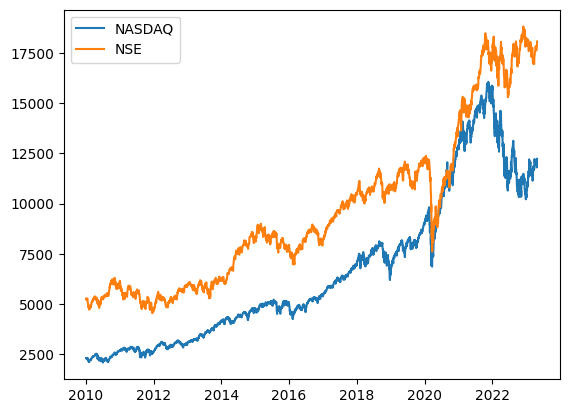

In [50]:
plt.plot(nasdaq.index, nasdaq['Close'], label='NASDAQ')
plt.plot(nse.index, nse['Close'], label='NSE')
plt.legend()

In [51]:
print(f"Corelation coefficient of the 2 indices is {nse['Close'].corr(nasdaq['Close'])}")

Corelation coefficient of the 2 indices is 0.9513138758576785


This shows that the indices are very strongly corelated, because the factor is 0.95 (95% corelation). The direction is positive, which means that both series increase together or decrease together.

Coding Keltner Channel for NASDAQ index - 

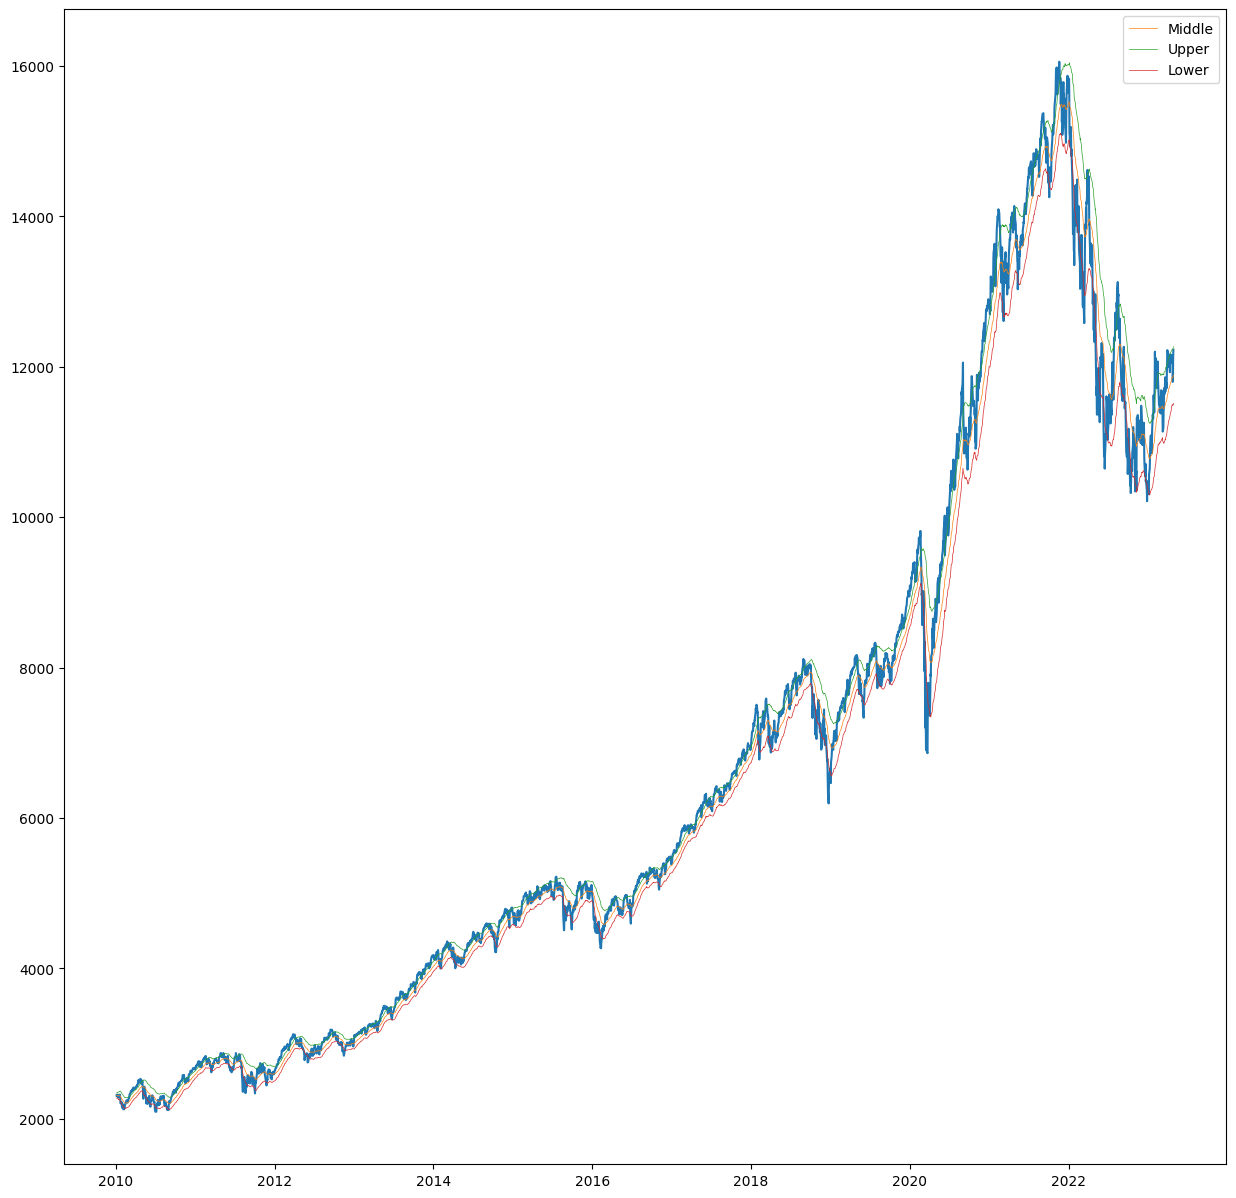

In [52]:
high = nasdaq['High']
low = nasdaq['Low']
close = nasdaq['Close']

tr1 = pd.DataFrame(high - low)
tr2 = pd.DataFrame(abs(high - close.shift()))
tr3 = pd.DataFrame(abs(low - close.shift()))
frames = [tr1, tr2, tr3]
true_range = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
average_true_range = true_range.ewm(alpha=0.05).mean()

kc_middle = close.ewm(20).mean()
kc_upper = close.ewm(20).mean() + 2 * average_true_range
kc_lower = close.ewm(20).mean() - 2 * average_true_range

plt.figure(figsize=(15,15))
plt.plot(nasdaq.index, nasdaq['Close'])
plt.plot(kc_middle.index, kc_middle, label='Middle', linewidth=0.5)
plt.plot(kc_upper.index, kc_upper, label='Upper', linewidth=0.5)
plt.plot(kc_lower.index, kc_lower, label='Lower', linewidth=0.5)
plt.legend()

Coding Bollinger Bands for NASDAQ index

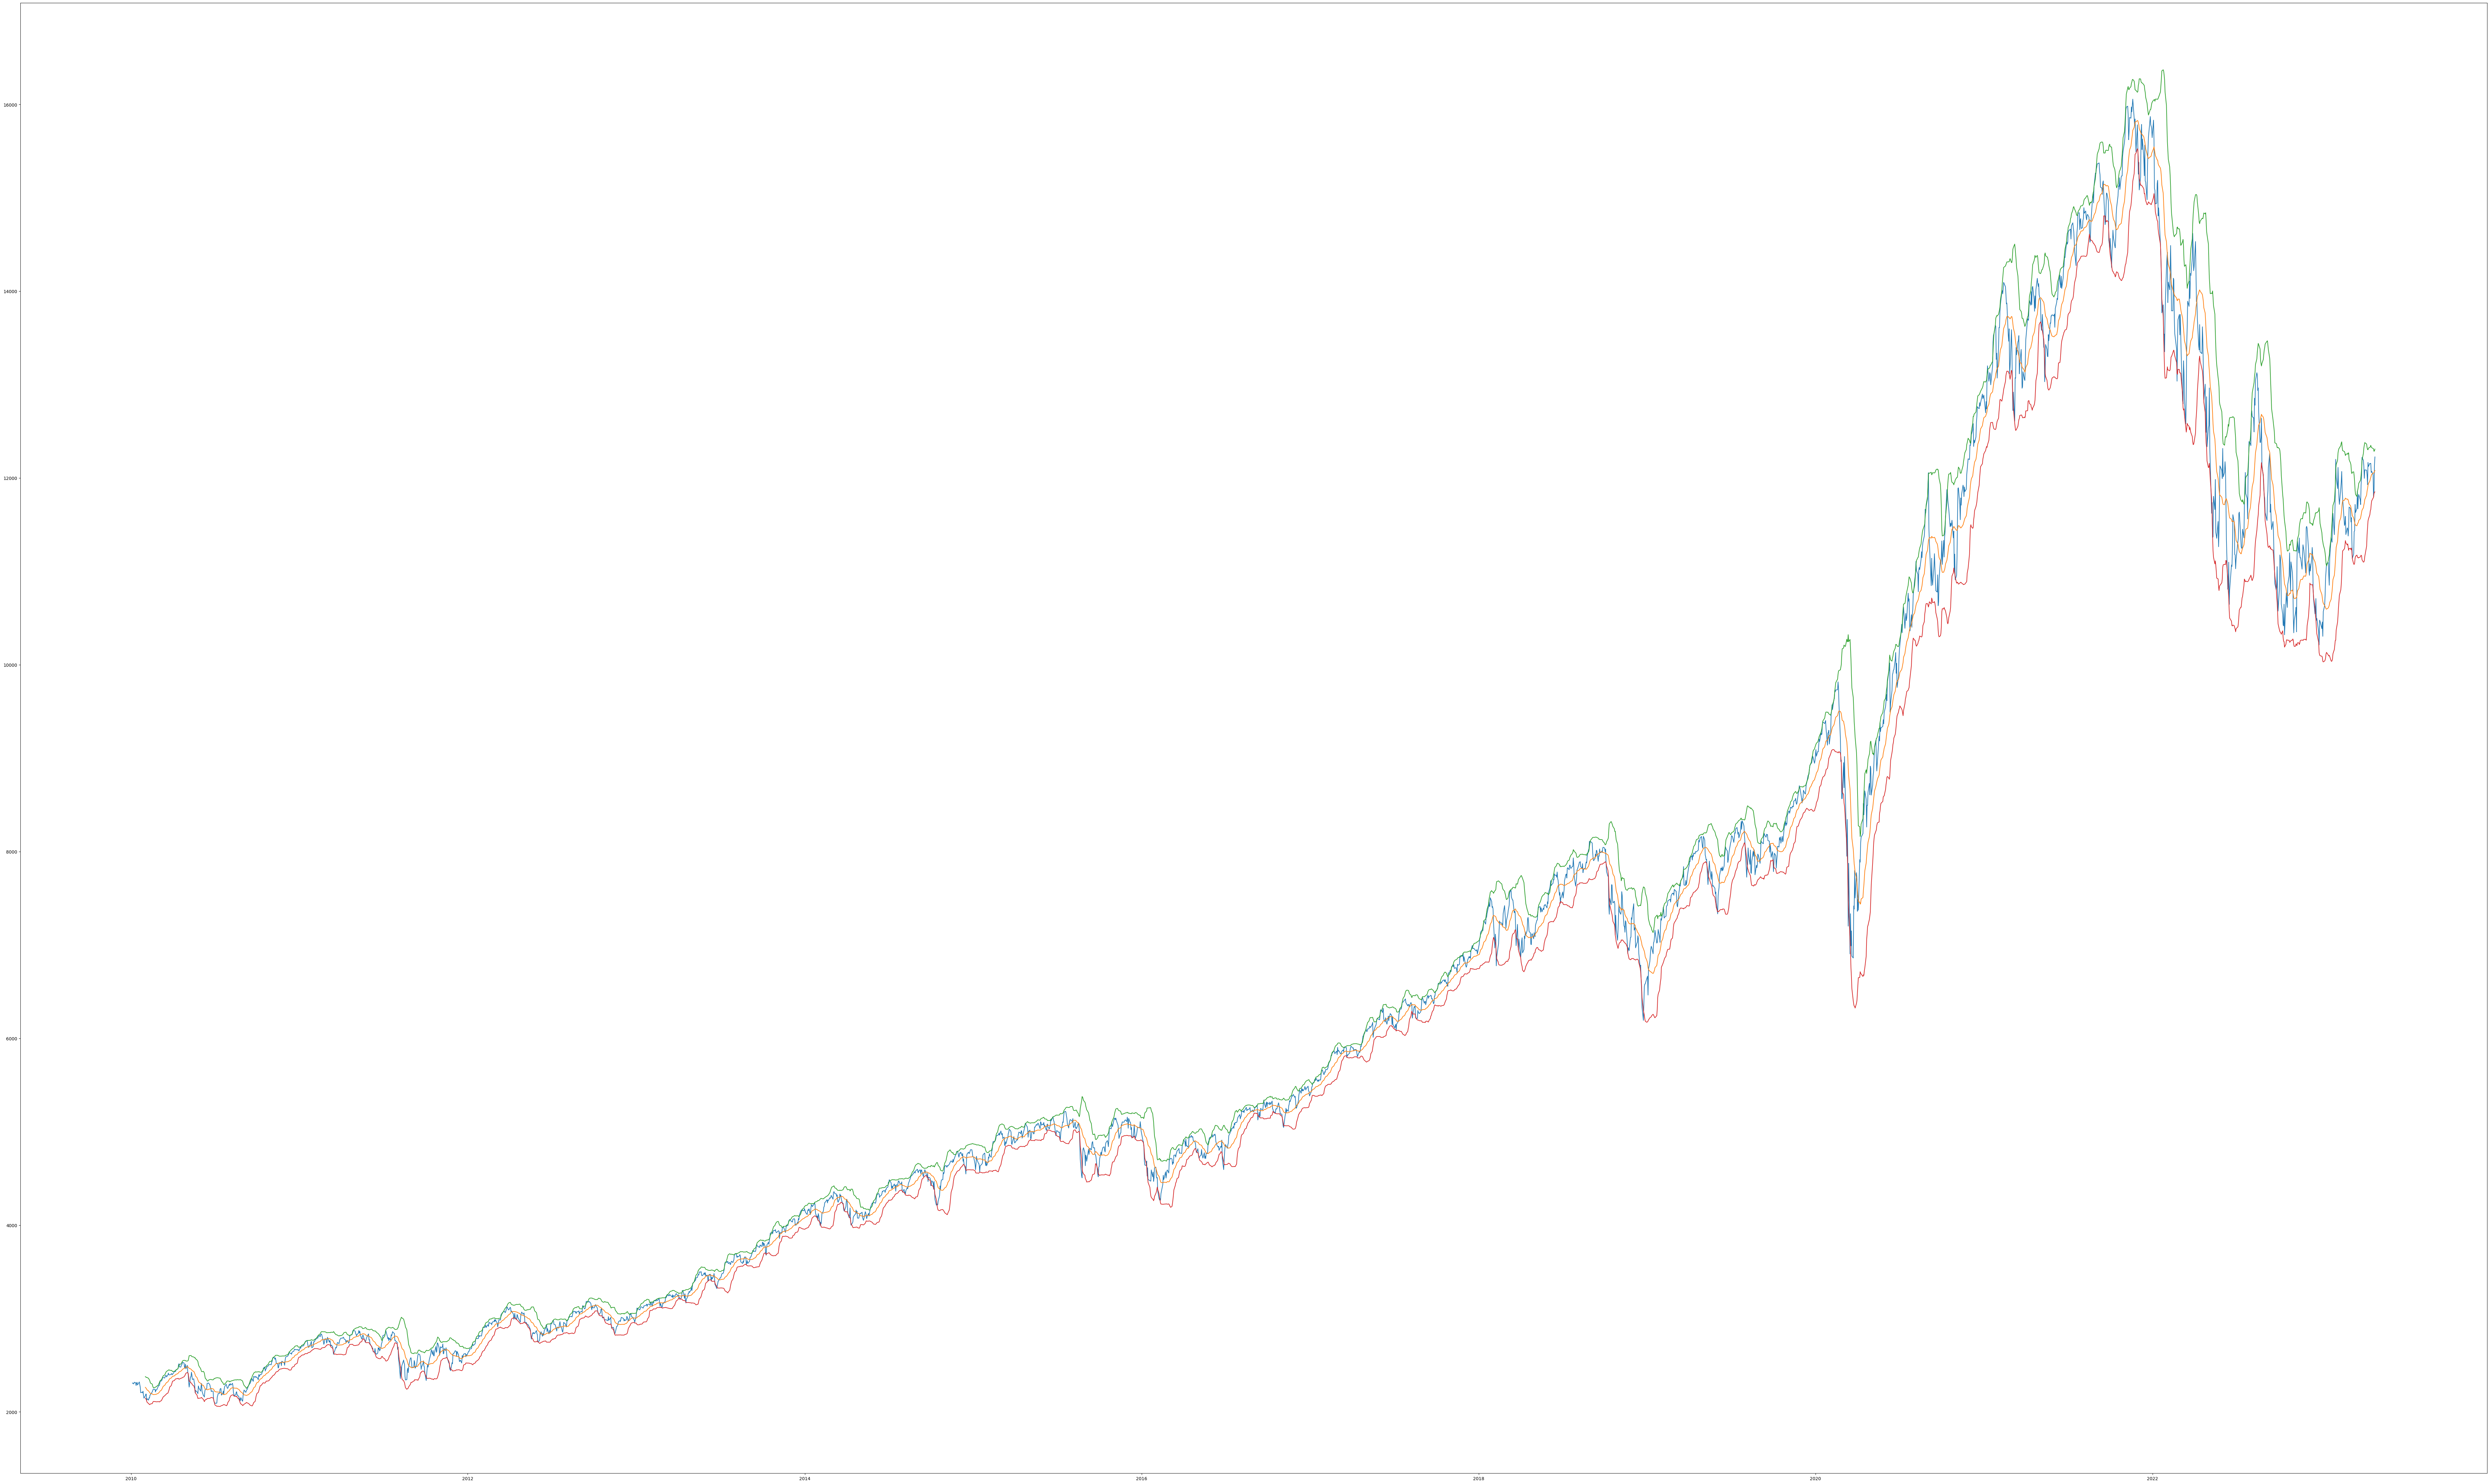

In [53]:
moving_average = pd.Series((close.rolling(20, min_periods=20).mean()))
deviation = close.rolling(20, min_periods=20).std()

plt.figure(figsize=(100,60))
plt.plot(nasdaq.index, close)
plt.plot(moving_average.index, moving_average)
plt.plot(moving_average.index, moving_average + 2 * deviation)
plt.plot(moving_average.index, moving_average - 2 * deviation)

Coding the MACD indicator for NASDAQ:

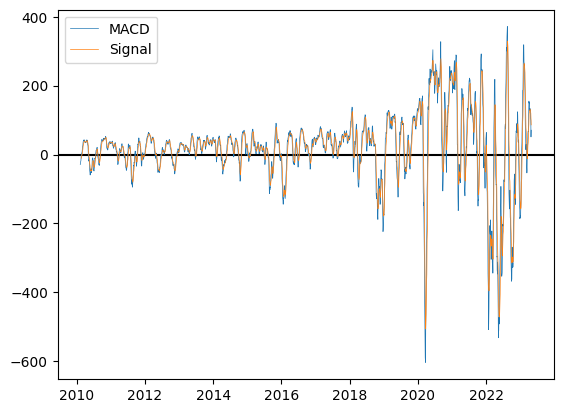

In [54]:
ema_26 = close.ewm(span=26, min_periods=26).mean()
ema_12 = close.ewm(span=12, min_periods=12).mean()

macd = ema_12 - ema_26
signal = macd.ewm(span=9, min_periods=9).mean()

plt.axhline(0, color='black')
plt.plot(macd.index, macd, label='MACD', linewidth=0.5)
plt.plot(signal.index, signal, label='Signal', linewidth=0.5)
plt.legend()

Let us plot the graphs of NSE and NASDAQ again for the last 1 year to identify potential lead-lag relationship

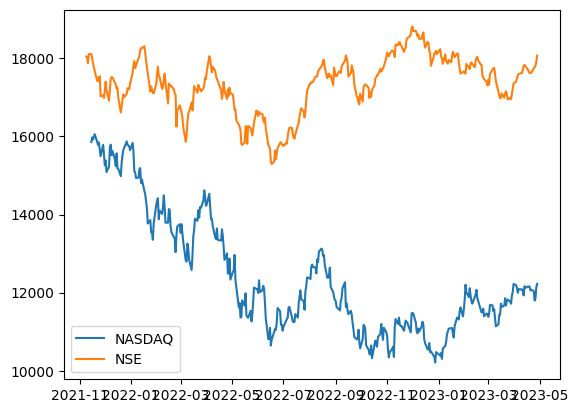

In [55]:
plt.plot(nasdaq.index[-365:], nasdaq['Close'][-365:], label="NASDAQ")
plt.plot(nse.index[-365:], nse['Close'][-365:], label="NSE")
plt.legend()

We can see that NSE index is affected few days late after the NASDAQ index, which means that they have a lead-lag relationship. Hence, we will optimise the parameters for the NASDAQ index and use the results to gain profit on the NSE index.

In [56]:
nasdaq['MACD'] = nasdaq['Close'].ewm(span=12, min_periods=12).mean() - nasdaq['Close'].ewm(span=26, min_periods=26).mean()
nasdaq['MACD_Signal'] = nasdaq['MACD'].ewm(span=9, min_periods=9).mean()

nasdaq

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_Signal
Date,,,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000,NaN,NaN
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000,NaN,NaN
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000,NaN,NaN
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000,NaN,NaN
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-04-24,12053.469727,12103.580078,11960.299805,12037.200195,12037.200195,4854050000,98.871693,119.419535
2023-04-25,11968.809570,11990.459961,11798.769531,11799.160156,11799.160156,4806020000,70.095771,109.554782
2023-04-26,11913.230469,11967.990234,11833.070312,11854.349609,11854.349609,5281970000,51.154298,97.874685


In [57]:
status = 'SELL'  # first should be bought so prev sold
buy_price = []
sell_price = []
macd_signals = []

for i in range(len(nasdaq['Close'])):
    if nasdaq['MACD'][i] > nasdaq['MACD_Signal'][i]:
        if status != 'BUY':
            buy_price.append(nasdaq['Close'][i])
            sell_price.append(np.nan)
            macd_signals.append(1)
            status = 'BUY'
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signals.append(0)
    elif nasdaq['MACD'][i] < nasdaq['MACD_Signal'][i]:
        if status != 'SELL':
            buy_price.append(np.nan)
            sell_price.append(nasdaq['Close'][i])
            macd_signals.append(-1)
            status = 'SELL'
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signals.append(0)
    else:
        buy_price.append(np.nan)
        sell_price.append(np.nan)
        macd_signals.append(0)

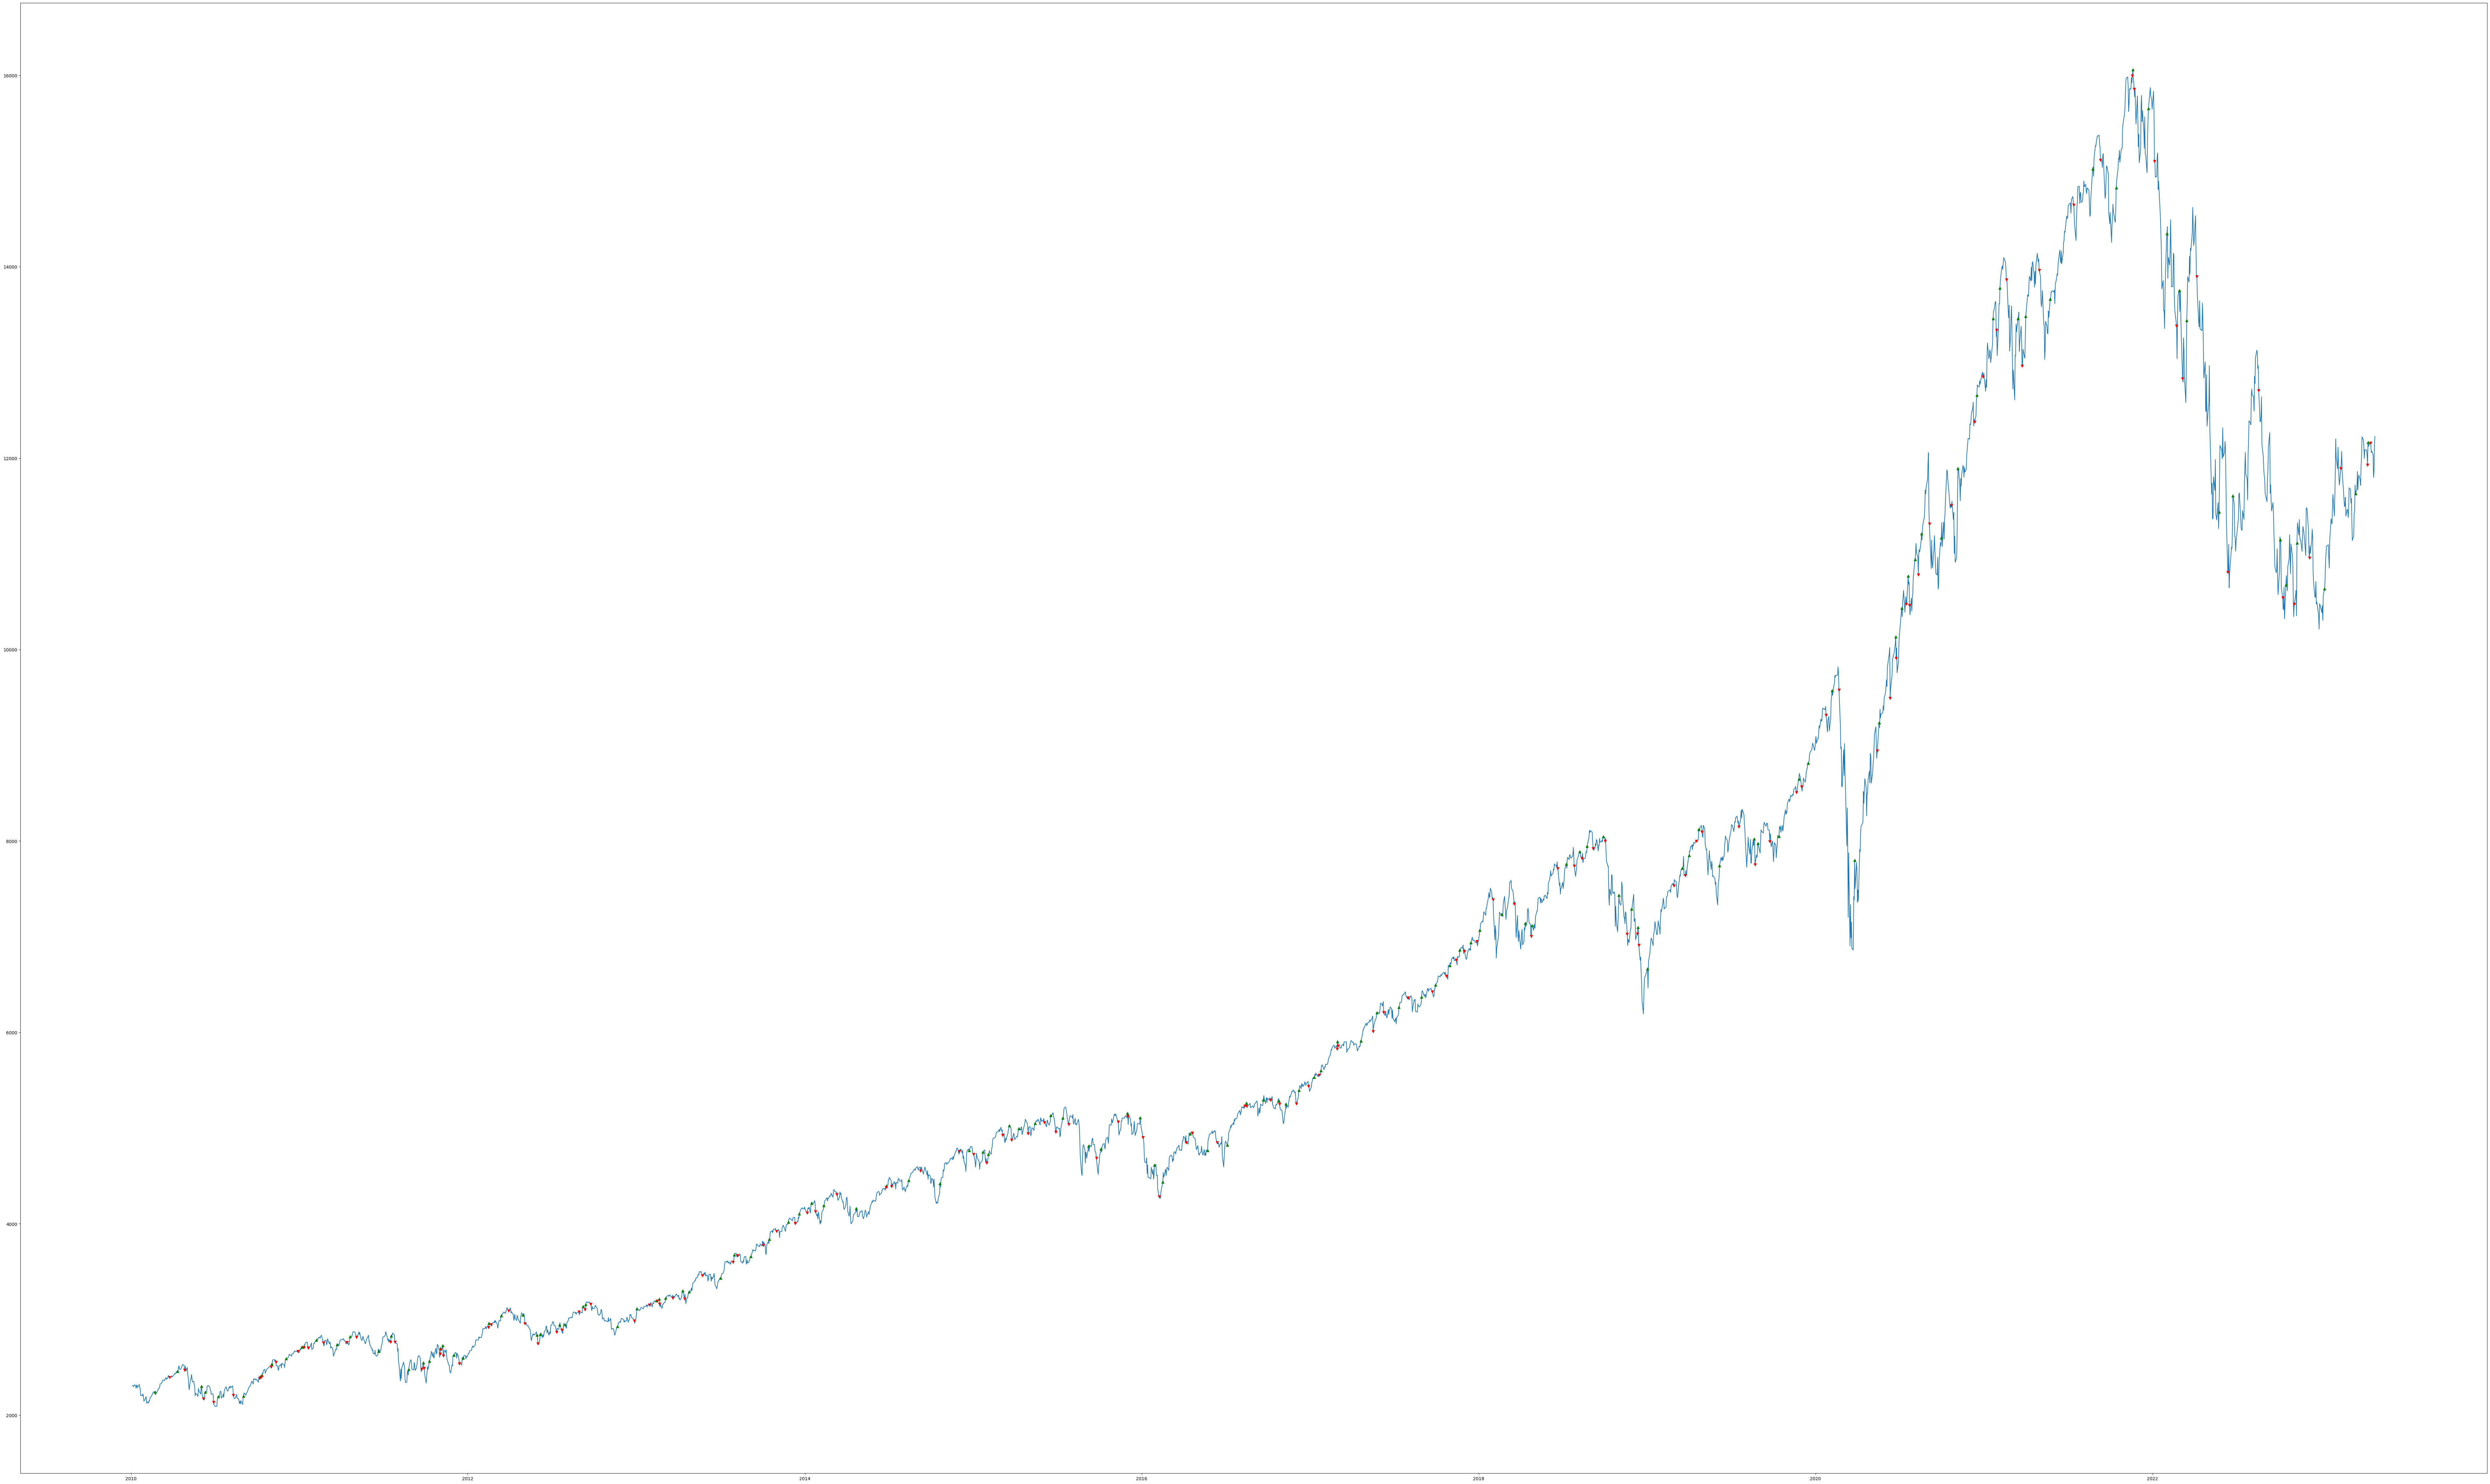

In [58]:
plt.figure(figsize=(100,60))
plt.plot(nasdaq['Close'].index, nasdaq['Close'])
plt.plot(nasdaq['Close'].index, buy_price, color='green', marker='^')
plt.plot(nasdaq['Close'].index, sell_price, color='red', marker='v')


In [59]:
macd_position = [0]*len(macd_signals)

for i in range(len(nasdaq['Close'])):
    if macd_signals[i] == 1:
        macd_position[i] = 1
    elif macd_signals[i] == -1:
        macd_position[i] = 0
    else:
        macd_position[i] = macd_position[i-1]

In [60]:
macd = nasdaq['MACD']
signal = nasdaq['MACD_Signal']
close = nasdaq['Close']
macd_signal = pd.DataFrame(macd_signals).rename(columns={0:'MACD_Signals'}).set_index(nasdaq.index)
macd_position = pd.DataFrame(macd_position).rename(columns={0:'MACD_Position'}).set_index(nasdaq.index)

strategy = pd.concat([close, macd, signal, macd_signal, macd_position], join='inner', axis=1)
strategy.tail()

,Close,MACD,MACD_Signal,MACD_Signals,MACD_Position
Date,,,,,
2023-04-24,12037.200195,98.871693,119.419535,0,0
2023-04-25,11799.160156,70.095771,109.554782,0,0
2023-04-26,11854.349609,51.154298,97.874685,0,0
2023-04-27,12142.240234,58.696791,90.039106,0,0
2023-04-28,12226.580078,70.665208,86.164327,0,0


In [61]:
returns = np.diff(nasdaq['Close'])
macd_returns = []

for i in range(len(returns)):
    macd_returns.append(returns[i] * strategy['MACD_Position'][i])

intitial_investment = 1000000
n = np.floor(intitial_investment / nasdaq['Close'][0])
macd_investment_returns = []

for i in range(len(macd_returns)):
    macd_investment_returns.append(n * macd_returns[i])

total_returns = sum(macd_investment_returns)
profit = total_returns / intitial_investment

print(f"Net returns = {np.round(total_returns, 2)}, profit percentage = {np.round(profit, 2) * 100}%")

Net returns = 3049276.7, profit percentage = 305.0%


Let us define functions to directly calculate all metrics for the 3 indicators:

In [106]:
def get_macd_returns(ema_less, ema_more, ema_macd, stock):
    close = stock['Close']
    macd = close.ewm(span=ema_less, min_periods=ema_less).mean() - close.ewm(span=ema_more, min_periods=ema_more).mean()
    macd_signal = macd.ewm(span=ema_macd, min_periods=ema_macd).mean()
    
    status = 'SELL'  # first should be bought so prev sold
    buy_price = []
    sell_price = []
    macd_signals = []

    for i in range(len(close)):
        if macd[i] > macd_signal[i]:
            if status != 'BUY':
                buy_price.append(close[i])
                sell_price.append(np.nan)
                macd_signals.append(1)
                status = 'BUY'
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signals.append(0)
        elif macd[i] < macd_signal[i]:
            if status != 'SELL':
                buy_price.append(np.nan)
                sell_price.append(close[i])
                macd_signals.append(-1)
                status = 'SELL'
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signals.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signals.append(0)
    
    macd_position = []
    for i in range(len(macd_signals)):
        if macd_signals[i] > 1:
            macd_position.append(0)
        else:
            macd_position.append(1)
            
    for i in range(len(close)):
        if macd_signals[i] == 1:
            macd_position[i] = 1
        elif macd_signals[i] == -1:
            macd_position[i] = 0
        else:
            macd_position[i] = macd_position[i-1]

    returns = np.diff(close)
    
    macd_returns = []

    for i in range(len(returns)):
        macd_returns.append(returns[i] * macd_position[i])

    intitial_investment = 1000000
    n = np.floor(intitial_investment / close[0])
    macd_investment_returns = []

    for i in range(len(macd_returns)):
        macd_investment_returns.append(n * macd_returns[i])

    total_returns = sum(macd_investment_returns)
    profit = total_returns / intitial_investment
    sharpe_ratio = (np.mean(macd_investment_returns) * 252 - 3.5/100)/np.std(macd_investment_returns)

    returns = pd.Series(returns)
    max_drawdown = (returns.cumsum() - returns.cumsum().cummax()).min()

    print(f"MACD profit percentage = {profit * 100}%")    
    print(f"MACD sharpe ratio = {sharpe_ratio}")   
    print(f"MACD max_drawdown = {max_drawdown}")   


In [107]:
get_macd_returns(12, 26, 9, nasdaq)

MACD profit percentage = 302.0529878173828%
MACD sharpe ratio = 7.9326786798757585
MACD max_drawdown = -5844.150390625


Doing similar for Keltner Channel:

In [96]:
def get_kc_returns(kc_ewm, atr_ewm, multiplier, stock):
    high = stock['High']
    low = stock['Low']
    close = stock['Close']

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    true_range = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    average_true_range = true_range.ewm(alpha=1/atr_ewm).mean()

    kc_upper = close.ewm(kc_ewm).mean() + multiplier * average_true_range
    kc_lower = close.ewm(kc_ewm).mean() - multiplier * average_true_range

    status = 'SELL'  # first should be bought so prev sold
    buy_price = []
    sell_price = []
    kc_signals = []

    for i in range(len(close)):
        if close[i] < kc_lower[i]:
            if status != 'BUY':
                buy_price.append(close[i])
                sell_price.append(np.nan)
                kc_signals.append(1)
                status = 'BUY'
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signals.append(0)
        elif close[i] > kc_upper[i]:
            if status != 'SELL':
                buy_price.append(np.nan)
                sell_price.append(close[i])
                kc_signals.append(-1)
                status = 'SELL'
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signals.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signals.append(0)
    
    kc_position = []
    for i in range(len(kc_signals)):
        if kc_signals[i] > 1:
            kc_position.append(0)
        else:
            kc_position.append(1)
            
    for i in range(len(close)):
        if kc_signals[i] == 1:
            kc_position[i] = 1
        elif kc_signals[i] == -1:
            kc_position[i] = 0
        else:
            kc_position[i] = kc_position[i-1]

    returns = np.diff(close)
    
    kc_returns = []

    for i in range(len(returns)):
        kc_returns.append(returns[i] * kc_position[i])

    intitial_investment = 1000000
    n = np.floor(intitial_investment / close[0])
    kc_investment_returns = []

    for i in range(len(kc_returns)):
        kc_investment_returns.append(n * kc_returns[i])

    total_returns = sum(kc_investment_returns)
    profit = total_returns / intitial_investment
    
    kc_returns = pd.Series(kc_returns)
    max_drawdown = (kc_returns.cumsum() - kc_returns.cumsum().cummax()).min()

    print(f"Keltner Channels profit percentage = {profit * 100}%")    
    print(f"Keltner Channels sharpe ratio = {(np.mean(kc_investment_returns) * 252 - 3.5/100)/np.std(kc_investment_returns)}")   
    print(f"Keltner Channels max drawdown = {max_drawdown}")   

In [97]:
get_kc_returns(10, 10, 2, nasdaq)

Keltner Channels profit percentage = 267.42427795410157%
Keltner Channels sharpe ratio = 5.542385352189226
Keltner Channels max drawdown = -2358.75


In [103]:
def get_bollinger_returns(period,  multiplier, stock):
    close = stock['Close']
    
    moving_average = pd.Series((close.rolling(period, min_periods=period).mean()))
    deviation = close.rolling(period, min_periods=period).std()

    b_upper = moving_average + multiplier * deviation
    b_lower = moving_average - multiplier * deviation

    status = 'SELL'  # first should be bought so prev sold
    buy_price = []
    sell_price = []
    b_signals = []

    for i in range(len(close)):
        if close[i] < b_lower[i]:
            if status != 'BUY':
                buy_price.append(close[i])
                sell_price.append(np.nan)
                b_signals.append(1)
                status = 'BUY'
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                b_signals.append(0)
        elif close[i] > b_upper[i]:
            if status != 'SELL':
                buy_price.append(np.nan)
                sell_price.append(close[i])
                b_signals.append(-1)
                status = 'SELL'
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                b_signals.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            b_signals.append(0)
    
    b_position = []
    for i in range(len(b_signals)):
        if b_signals[i] > 1:
            b_position.append(0)
        else:
            b_position.append(1)
            
    for i in range(len(close)):
        if b_signals[i] == 1:
            b_position[i] = 1
        elif b_signals[i] == -1:
            b_position[i] = 0
        else:
            b_position[i] = b_position[i-1]

    returns = np.diff(close)
    
    b_returns = []

    for i in range(len(returns)):
        b_returns.append(returns[i] * b_position[i])

    intitial_investment = 1000000
    n = np.floor(intitial_investment / close[0])
    b_investment_returns = []

    for i in range(len(b_returns)):
        b_investment_returns.append(n * b_returns[i])

    total_returns = sum(b_investment_returns)
    profit = total_returns / intitial_investment
    b_returns = pd.Series(b_returns)
    max_drawdown = (b_returns.cumsum() - b_returns.cumsum().cummax()).min()

    print(f"Bollinger profit percentage = {profit * 100}%")
    print(f"Bollinger sharpe ratio = {(np.mean(b_investment_returns) * 252 - 3.5/100)/np.std(b_investment_returns)}")   
    print(f"Bollinger max drawdown = {max_drawdown}")   

In [104]:
get_bollinger_returns(20, 2, nasdaq)

Bollinger profit percentage = 220.25498530273438%
Bollinger sharpe ratio = 4.06679263062696
Bollinger max drawdown = -5964.169921875


In [112]:
get_macd_returns(9, 26, 9, nasdaq)
print()
get_bollinger_returns(20, 2, nasdaq)
print()
get_kc_returns(20, 20, 2, nasdaq)

MACD profit percentage = 267.3231530029297%
MACD sharpe ratio = 7.02382719072023
MACD max_drawdown = -5844.150390625

Bollinger profit percentage = 220.25498530273438%
Bollinger sharpe ratio = 4.06679263062696
Bollinger max drawdown = -5964.169921875

Keltner Channels profit percentage = 254.0498424560547%
Keltner Channels sharpe ratio = 5.237076610459065
Keltner Channels max drawdown = -2467.30078125


Optimising parameters for MACD:

In [113]:
get_macd_returns(9, 26, 9, nasdaq)
get_macd_returns(19, 39, 9, nasdaq)
get_macd_returns(5, 13, 9, nasdaq)

MACD profit percentage = 267.3231530029297%
MACD sharpe ratio = 7.02382719072023
MACD max_drawdown = -5844.150390625
MACD profit percentage = 125.97702634277343%
MACD sharpe ratio = 3.378905250111159
MACD max_drawdown = -5844.150390625
MACD profit percentage = 221.68279645996094%
MACD sharpe ratio = 5.570255046671027
MACD max_drawdown = -5844.150390625


Optimising parameters for Keltner Channel:

In [114]:
get_kc_returns(20, 20, 2, nasdaq)
get_kc_returns(10, 20, 2, nasdaq)
get_kc_returns(30, 20, 2, nasdaq)

Keltner Channels profit percentage = 254.0498424560547%
Keltner Channels sharpe ratio = 5.237076610459065
Keltner Channels max drawdown = -2467.30078125
Keltner Channels profit percentage = 323.17987814941404%
Keltner Channels sharpe ratio = 6.411635031816979
Keltner Channels max drawdown = -2360.6103515625
Keltner Channels profit percentage = 196.78160708007812%
Keltner Channels sharpe ratio = 4.124245811562957
Keltner Channels max drawdown = -3973.5400390625


Optimising parameters for Bollinger Bands:

In [115]:
get_bollinger_returns(20, 2, nasdaq)
get_bollinger_returns(10, 2, nasdaq)
get_bollinger_returns(30, 2, nasdaq)

Bollinger profit percentage = 220.25498530273438%
Bollinger sharpe ratio = 4.06679263062696
Bollinger max drawdown = -5964.169921875
Bollinger profit percentage = 356.07757114257817%
Bollinger sharpe ratio = 6.120821609492567
Bollinger max drawdown = -5736.05078125
Bollinger profit percentage = 449.7336634521484%
Bollinger sharpe ratio = 9.401139648069309
Bollinger max drawdown = -3290.0400390625


Using optimised parameters for calculating returns on NSE: 

In [117]:
get_macd_returns(9, 26, 9, nse)
print()
get_kc_returns(10, 20, 9, nse)
print()
get_bollinger_returns(30, 2, nse)
print()

MACD profit percentage = 194.01786528320312%
MACD sharpe ratio = 12.24986858458818
MACD max_drawdown = -4752.0498046875

Keltner Channels profit percentage = 245.10647626953124%
Keltner Channels sharpe ratio = 9.277907825880158
Keltner Channels max drawdown = -4752.0498046875

Bollinger profit percentage = 123.73549829101562%
Bollinger sharpe ratio = 5.979125182355043
Bollinger max drawdown = -5166.19921875

